In [1]:
import pandas as pd
import numpy as np
import random
import os
import sys
import statsmodels.api as sm
import scipy.stats as ss
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, explained_variance_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
style.use('fivethirtyeight')
plt.rcParams['figure.dpi'] = 600
# plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2
sns.set()
sns.set_style('white')

In [3]:
RANDOM_SEED = 77777

In [4]:
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [5]:
df = pd.read_csv('../data/pop_snps.csv')

In [6]:
df.head()

,subject,phenotype,rs1003306_A,rs1003306_T,rs1003306_C,rs1003306_G,rs1011340_A,rs1011340_T,rs1011340_C,rs1011340_G,...,rs986642_C,rs986642_G,rs998401_A,rs998401_T,rs998401_C,rs998401_G,rs9993173_A,rs9993173_T,rs9993173_C,rs9993173_G
0,hu91BD69,1,0,0,0,0,1,0,1,0,...,1,1,0,0,0,0,0,1,0,1
1,hu42B208,0,0,0,0,0,0,0,2,0,...,1,1,0,0,0,0,0,2,0,0
2,huBFEDCE,1,0,0,0,0,0,0,2,0,...,2,0,0,0,0,0,0,2,0,0
3,hu7AC640,1,0,0,0,0,1,0,1,0,...,2,0,0,0,0,0,0,1,0,1
4,huA3A815,1,0,0,0,0,0,0,2,0,...,1,1,0,0,0,0,0,2,0,0


In [7]:
IDs = list(df['subject'])
y = df['phenotype']
X = df.drop(columns=['subject', 'phenotype'], axis=1, inplace=False)

In [8]:
IDs

['hu91BD69',
 'hu42B208',
 'huBFEDCE',
 'hu7AC640',
 'huA3A815',
 'hu409F2D',
 'hu6E9C24',
 'hu41ED75',
 'huD83C6C',
 'hu993257',
 'hu5F0DCB',
 'huBE8E0C',
 'hu3F864B',
 'hu606C9D',
 'hu82436A',
 'huB828CB',
 'hu43860C',
 'huDDE04F',
 'huF99A55',
 'hu0B51B8',
 'hu00147A',
 'hu345185',
 'hu448C4B',
 'huDDEC1D',
 'hu7ECB9C',
 'hu83E9B9',
 'hu459AD0',
 'huA5FD8B',
 'huC4F2BB',
 'hu39D07D',
 'hu44DCFF',
 'hu84B706',
 'hu48C4EB']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [10]:
np_Xtr, np_Ytr = np.array(X_train), np.array(y_train)

In [11]:
kf = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

In [12]:
forest_sizes = [1, 5, 10, 25, 50, 100, 250, 500, 750, 1000]

In [13]:
depths = np.linspace(1, 10, 10)

In [14]:
mean_valid_accuracies = []

In [15]:
for forest_size in forest_sizes:
    for depth in depths:
        sub_valid_accuracies = []
        for train_ind, valid_ind in kf.split(np_Xtr):
            kf_X_train, kf_X_valid, kf_y_train, kf_y_valid = np_Xtr[train_ind], np_Xtr[valid_ind], np_Ytr[train_ind], np_Ytr[valid_ind]
            clf = RandomForestClassifier(n_estimators=forest_size, max_depth=depth, criterion='gini', max_features=1/3, 
                                    bootstrap=True, n_jobs=-1, random_state=RANDOM_SEED)
            clf.fit(kf_X_train, kf_y_train)
            
            kf_y_valid_pred = clf.predict(kf_X_valid)
            sub_valid_accuracies += [accuracy_score(kf_y_valid, kf_y_valid_pred, normalize=True)]
            
        mean_valid_accuracies += [np.mean(sub_valid_accuracies)]         

In [16]:
mean_valid_accuracies = np.array(mean_valid_accuracies).reshape((len(forest_sizes), len(depths)))

In [17]:
opt_acc = np.max(mean_valid_accuracies)

In [18]:
opt_ind = np.ravel(np.array(np.where(mean_valid_accuracies == opt_acc)))

In [19]:
opt_forest_size, opt_depth = forest_sizes[opt_ind[0]], depths[opt_ind[1]]

In [20]:
x_plot = forest_sizes
y_plot = depths
z_plot = mean_valid_accuracies

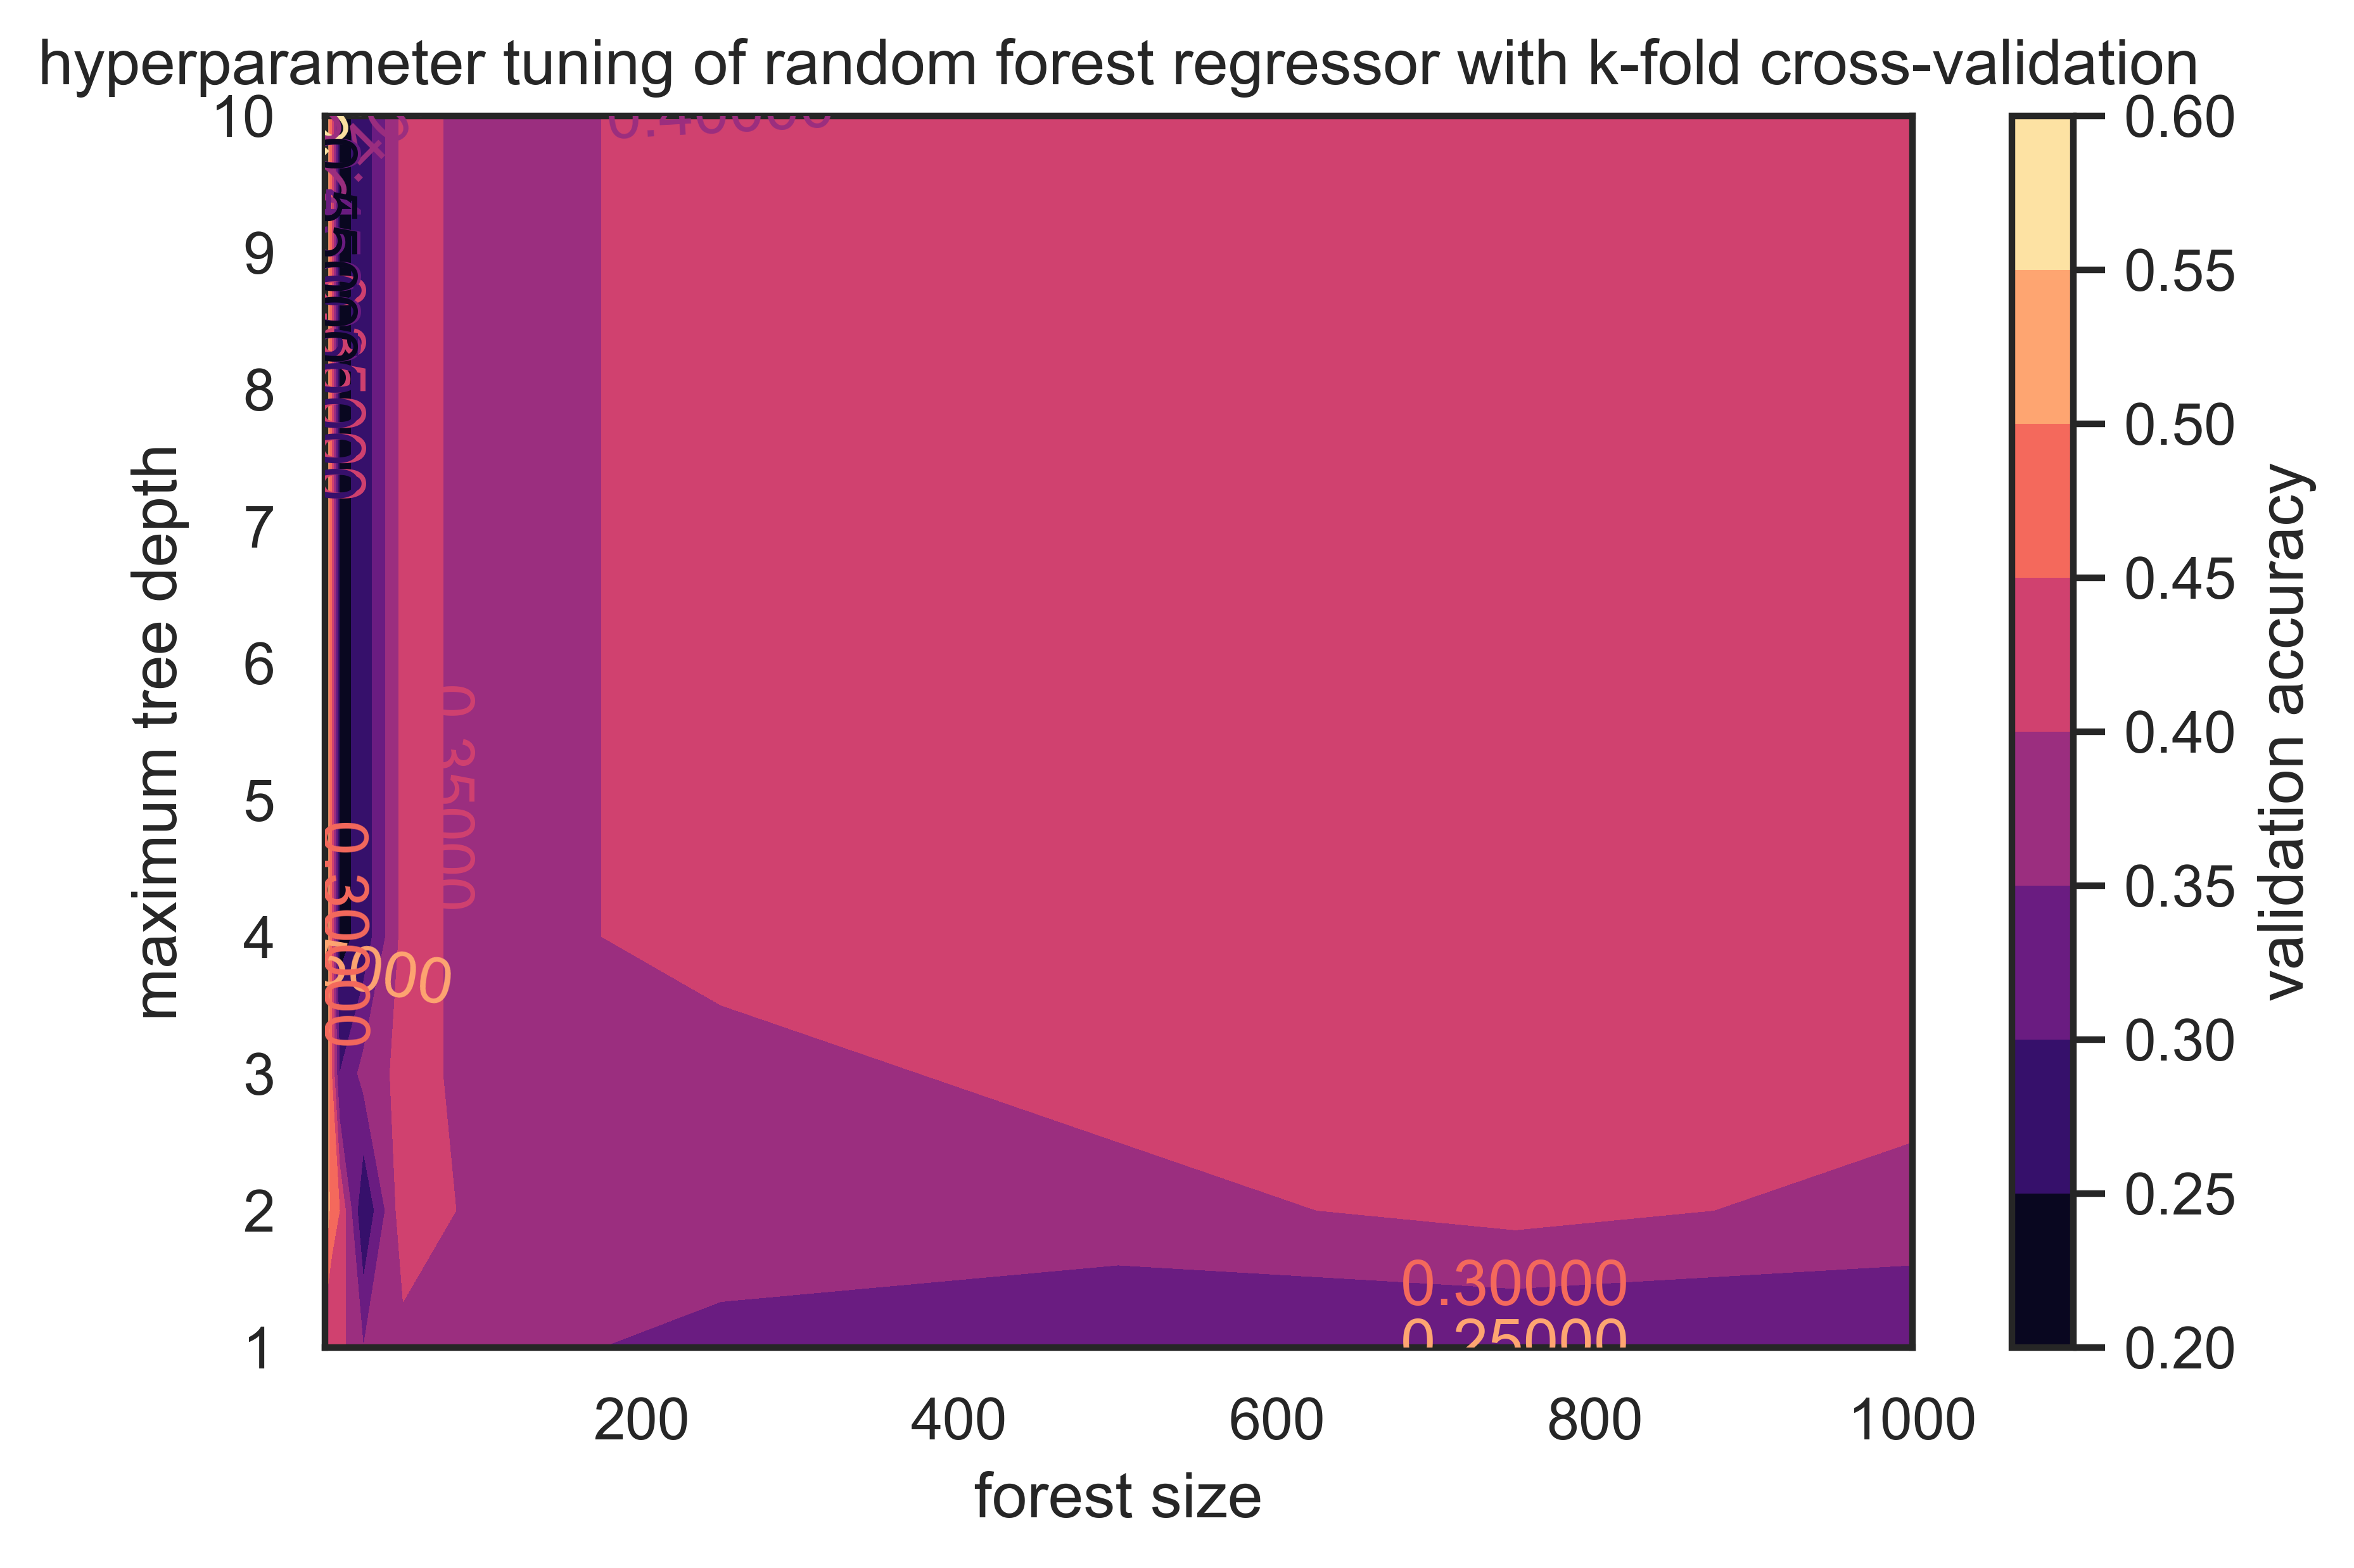

In [21]:
fig1, ax1 = plt.subplots()
isoc = ax1.contourf(x_plot, y_plot, z_plot.T, cmap=plt.get_cmap('magma_r'))
isoc2 = ax1.contourf(x_plot, y_plot, z_plot.T, cmap=plt.get_cmap('magma'))
cbar = fig1.colorbar(isoc2)
cbar.ax.set_ylabel('validation accuracy')
ax1.clabel(isoc, inline=1, fmt='%1.5f', fontsize=12)
ax1.set_xlabel('forest size')
ax1.set_ylabel('maximum tree depth')
ax1.set_title('hyperparameter tuning of random forest regressor with k-fold cross-validation')
plt.show()

In [22]:
print('optimal forest size: {}'.format(opt_forest_size))
print('optimal maximum tree depth: {}'.format(opt_depth))

optimal forest size: 1
optimal maximum tree depth: 1.0


In [23]:
def perm_fi(clf, X, y, opt_acc):
    """
    Compute permutation feature importances on dataset

    :param clf:
    :param X:
    :param y:
    :param opt_loss
    :return:
    """
    SNPs = [_.split('_')[0] for _ in list(X.columns)]
    SNPs = [SNPs[_] for _ in range(len(SNPs)) if not (_%4)]
    
    fimp = []
    features = []
    for _ in range(len(SNPs)):
        feature = SNPs[_]
        features += [feature]
        
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
        clf.fit(X_train, y_train)

        '''
        Generate feature matrix Xperm by permuting feature j in the data X. 
        This breaks the association between feature j and true outcome y.
        '''
        Xperm_valid = np.copy(X_valid)
        for __ in range(4):
            np.random.shuffle(Xperm_valid[:, _*4+__])
        Xperm_valid = pd.DataFrame(data=Xperm_valid, columns=X.columns)

        y_valid_pred = clf.predict(Xperm_valid)
        perm_acc = accuracy_score(y_valid, y_valid_pred, normalize=True)
        fimp += [perm_acc - opt_acc]

    return fimp, features

In [ ]:
fimp, features = perm_fi(clf, X, y, opt_acc)
top10 = sorted(range(len(fimp)), key=lambda _: fimp[_], reverse=True)[:10]

In [ ]:
fig1, ax1 = plt.subplots()
ax1.bar([features[_] for _ in top10], [fimp[_] for _ in top10])
ax1.set_xticklabels([features[_] for _ in top10], rotation=90)
ax1.set_xlabel('feature')
ax1.set_ylabel('permutation importance')
ax1.set_title('feature importance using random forest classifier')
plt.show()